# Example: Snell's Law Raytracing vs. Gradient-based raytracing in a stratified medium

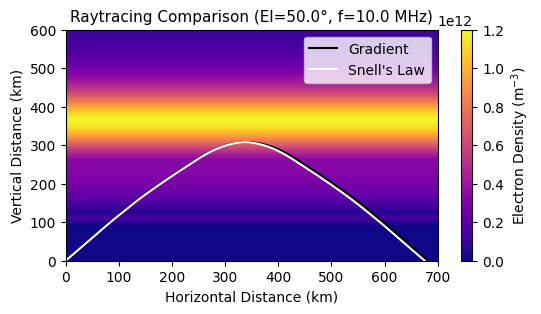

--------------------------------------------------
Gradient-based raytracing in a stratified medium:
--------------------------------------------------
Group Path (km):  935.5223347433675
Group delay (sec):  0.0035463863283177873
Ground_ Range (km):  681.0191948215835
x midpoint (km):  363.9771573947105
z midpoint (km):  305.0699596730053
--------------------------------------------------
Snell's Law Raytracing:
--------------------------------------------------
Group Path (km):  929.1301673496166
Group delay (sec):  0.0035100005520780583
Ground Range (km):  675.620220419237
x midpoint (km):  328.1517796293652
z midpoint (km):  307.0
--------------------------------------------------
% Difference:
--------------------------------------------------
Group Path: 0.688 %
Group delay: 1.04 %
Ground Range: 0.799 %
x midpoint: 10.9 %
z midpoint: -0.629 %


In [3]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PyRayHF.library import find_X, find_Y, find_mu_mup
from PyRayHF.library import build_refractive_index_interpolator
from PyRayHF.library import trace_ray_cartesian_gradient, trace_ray_cartesian_stratified
from scipy.interpolate import RegularGridInterpolator

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create this input file using
# PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))
alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]
h_ground = 0

# Ensure ground level is included
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6
mode = 'O'

# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = 1000
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
Babs_grid = np.tile(Babs[:, np.newaxis], (1, nx))
bpsi_grid = np.tile(bpsi[:, np.newaxis], (1, nx))

# In this case let's NOT add any gradient
Ne_gradient = Ne_grid

# Calculate plasma parameters
X = find_X(Ne_gradient, f0_Hz)
Y = find_Y(f0_Hz, Babs_grid)
mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)
mup0 = mup[0]

# Build interpolator from mup grid
n_and_grad = build_refractive_index_interpolator(z_grid, x_grid, mu)

# Build μ' for delay only calculation
mup_interp = RegularGridInterpolator((z_grid, x_grid),
                                     mup,
                                     bounds_error=False,
                                     fill_value=np.nan)

# Build interpolator for group index μ′
mup_interp = RegularGridInterpolator((z_grid, x_grid),
                                     mup,
                                     bounds_error=False,
                                     fill_value=np.nan)
mup_func = lambda x, z: mup_interp(np.column_stack([z, x]))

# Set initial conditions (e.g., launch from ground at x=0 with 50° elevation)
result = trace_ray_cartesian_gradient(n_and_grad=n_and_grad,
                                      x0_km=0.0,
                                      z0_km=0.0,
                                      elevation_deg=elevation_deg,
                                      s_max_km=4000.0,
                                      max_step_km=5.0,
                                      z_max_km=600.0,
                                      x_min_km=0.0,
                                      x_max_km=1000.0,
                                      mup_func=mup_func)

# Raytrace using Cartesian Snell's Law
result_stratified = trace_ray_cartesian_stratified(f0_Hz=f0_Hz,
                                                   elevation_deg=elevation_deg,
                                                   alt_km=alt_km,
                                                   Ne=Ne,
                                                   Babs=Babs,
                                                   bpsi=bpsi,
                                                   mode="O")

# Plot results
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 3)
ax_plot = ax
ax_plot.set_xlim(0, 700)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Distance (km)')
ax_plot.set_xlabel('Horizontal Distance (km)')
ax_plot.set_title(f"Raytracing Comparison (El={elevation_deg:.1f}°, f={f0_Hz/1e6} MHz)", fontsize=11)
vmin = 0
vmax = 1.2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax_plot.pcolormesh(Xg, Zg, Ne_gradient, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax_plot,
             ticks=color_ticks)
ax_plot.plot(result['x'], result['z'], c='black', label='Gradient')
ax_plot.plot(result_stratified['x'], result_stratified['z'], c='white', label='Snell\'s Law')
ax.legend()
plt.savefig('/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/examples/figures/Snells_vs_Gradient.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print('--------------------------------------------------')
print('Gradient-based raytracing in a stratified medium:')
print('--------------------------------------------------')
print('Group Path (km): ', result['group_path_km'])
print('Group delay (sec): ', result['group_delay_sec'])
print('Ground_ Range (km): ', result['ground_range_km'])
print('x midpoint (km): ', result['x_midpoint'])
print('z midpoint (km): ', result['z_midpoint'])


print('--------------------------------------------------')
print('Snell\'s Law Raytracing:')
print('--------------------------------------------------')
print('Group Path (km): ', result_stratified['group_path_km'])
print('Group delay (sec): ', result_stratified['group_delay_sec'])
print('Ground Range (km): ', result_stratified['ground_range_km'])
print('x midpoint (km): ', result_stratified['x_midpoint'])
print('z midpoint (km): ', result_stratified['z_midpoint'])

print('--------------------------------------------------')
print('% Difference:')
print('--------------------------------------------------')
print(f"Group Path: {(result['group_path_km'] / result_stratified['group_path_km']) * 100. - 100.:.3g} %")
print(f"Group delay: {(result['group_delay_sec'] / result_stratified['group_delay_sec']) * 100. - 100.:.3g} %")
print(f"Ground Range: {(result['ground_range_km'] / result_stratified['ground_range_km']) * 100. - 100.:.3g} %")
print(f"x midpoint: {(result['x_midpoint'] / result_stratified['x_midpoint']) * 100. - 100.:.3g} %")
print(f"z midpoint: {(result['z_midpoint'] / result_stratified['z_midpoint']) * 100. - 100.:.3g} %")

